In [1]:
import random
import itertools
import numpy as np
import pandas as pd
from scipy.special import logsumexp

from matplotlib import pyplot as plt

from Scripts import OrderedCategorySystem as OCS
from Scripts import generate_plots as plots
from Scripts import order_analyses as analyses

In [2]:
F =  [12, 13, 15, 14, 16, 18, 17, 19, 20]
B =  [20, 19, 17, 18, 16, 14, 15, 13, 12]
M1 =  [16, 17, 15, 18, 14, 19, 13, 20, 12]
M2 = [16, 15, 17, 14, 18, 13, 19, 12, 20]

NEW = [i for i in range(9, 24)]
ALL = NEW + [1, 3, 29, 31]

SHIFT = 3
DISTRACTORS = [1, 3, 29, 31]

ITEMS = ['I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23']

LEFT = ITEMS[:9]
CENTRE = ITEMS[3:12]
RIGHT = ITEMS[6:]

LOCS = [('L', LEFT),
        ('C', CENTRE), 
        ('R', RIGHT)]
ORDERS = [('f', 0, [1, 2, 3, 4, 5, 6, 7, 8]),
          ('m', 4, [0, 1, 2, 3, 5, 6, 7, 8]),
          ('b', 8, [0, 1, 2, 3, 4, 5, 6, 7])]

item_space = [i for i in range(1, 32)]

### Load Participant Data

In [3]:
allParticipants = pd.read_csv('../Analysis/Results/participant_data.csv')
allParticipants =  allParticipants[(allParticipants['ATTEMPTS'] < 3) & (allParticipants['TOTAL_ERRORS'] < 4)]
participants = allParticipants['P_ID'].tolist()

participant_df = pd.read_csv('../Analysis/Results/trial_data.csv')    
participant_df = participant_df[participant_df['P_ID'].isin(participants)]

cat_assigns = ITEMS + ['I01', 'I03', 'I29', 'I31']
others = participant_df.columns.difference(cat_assigns)

participant_df = (
    participant_df[others]
      .assign(ITEMS = participant_df[cat_assigns].agg(
            lambda row: {k: v for k, v in row.items() if not pd.isna(v)},
            axis=1
        )
      )
)
participant_trials = list(participant_df.to_dict('index').values())

In [91]:
def generate_possible_sets(order, loc):
    distract_orders =  list(itertools.permutations(DISTRACTORS))
    if order in ['f', 'b', 'm']: # Sequence
        if order == 'f':
            item_orders = [F]
        elif order == 'b':
            item_orders = [B]
        else:
            item_orders = [M1, M2]
    possible_orders = []
    for i_ord in item_orders:
        for d_ord in distract_orders:
            if loc == 'L':
                loc_ord = [i-SHIFT for i in i_ord]
            elif loc == 'R':
                loc_ord = [i+SHIFT for i in i_ord]
            else:
                loc_ord = i_ord
            final_ord = loc_ord[0:1] + [d_ord[0]] + loc_ord[1:4] + [d_ord[1]] + loc_ord[4:5] + [d_ord[2]] + loc_ord[5:8] + [d_ord[3]]+ loc_ord[8:9]
            possible_orders.append(final_ord)
    return possible_orders

def generate_all_orderings():
    order_dic = {}
    for loc in ['L', 'C', 'R']:
        for order in ['f', 'b', 'm']:
            order_dic[f'{loc}{order}'] = generate_possible_sets(order, loc)

    return order_dic

def get_participant_loglike(data, temp, alpha=0.0):
    total_log_like = 0.0
    worst = 0.0
    best = 0.0
    for trial in data:
        log_likes = []
        for possible_order in trial:
            sys_scores_array = np.array([s for s, _ in possible_order], dtype=np.float64)
            choice_indices = np.array([c for _, c in possible_order], dtype=int)
            probs = OCS.softmax(sys_scores_array, temp)
            K = probs.shape[1] 
            uniform = 1.0 / K
            p_choice = ((1 - alpha) * probs[np.arange(probs.shape[0]), choice_indices]) + (alpha * uniform)
            log_like = np.sum(np.log(p_choice))
            log_likes.append(log_like)
        worst += np.min(log_likes)
        best += np.max(log_likes)
        total_log_like += logsumexp(log_likes) - np.log(len(log_likes))
    return total_log_like, best, worst

# Assumes you've precomputed participant system scores
def get_total_log_like(participants, temp, alpha=0.0):
    total_log_like = 0.0
    best_ll = 0.0
    worst_ll = 0.0
    for data in participants.values():
        marginal, best, worst = get_participant_loglike(data, temp, alpha)
        total_log_like += marginal
        best_ll += best
        worst_ll += worst
    return total_log_like, best_ll, worst_ll

In [5]:
random.seed(13)
np.random.seed(13)

ordered_trials = [t for t in participant_trials if t['ORDER'] != 'a']
order_dic = generate_all_orderings()
allData, D, lookupTree = OCS.compute_possible_scores(ordered_trials, order_dic, item_space)


print(ordered_trials[0])

{'DEPTH': 2, 'ERRORS': 3, 'LOC': 'R', 'ORDER': 'm', 'POOL': 'prolific', 'P_ID': 'p001', 'STIMULI': 1, 'ITEMS': {'I15': 'X', 'I16': 'X', 'I17': 'X', 'I18': 'X', 'I19': 'X', 'I20': 'X', 'I21': 'X', 'I22': 'X', 'I23': 'B', 'I01': 'X', 'I03': 'X', 'I29': 'X', 'I31': 'B'}}


In [192]:
error_rate = np.mean([e['ERRORS']/4 for e in ordered_trials])
num2 = len([t for t in ordered_trials if t['DEPTH'] == 2])
num3 = len(ordered_trials) - num2
# for 2 level 
er2 = (3/2)*error_rate
# for 3 level
er3 = (7/4)*error_rate

print(f'Avg errors = {round(((er2*num2) + (er3)*num3)/len(ordered_trials), 2)}')

Avg errors = 0.07


In [ ]:
temps = np.linspace(0.5, 5, 46)
likes = [get_total_log_like(allData, t, 0.07) for t in temps]
likes = [l[0] for l in likes]
plt.plot(temps, likes)
print(temps[np.argmax(likes)])

In [191]:
model_likelihood = get_total_log_like(allData, 1.7, 0.07)
print(model_likelihood)

(-6249.284810760024, -5928.913215735292, -6770.798666967512)


0.15


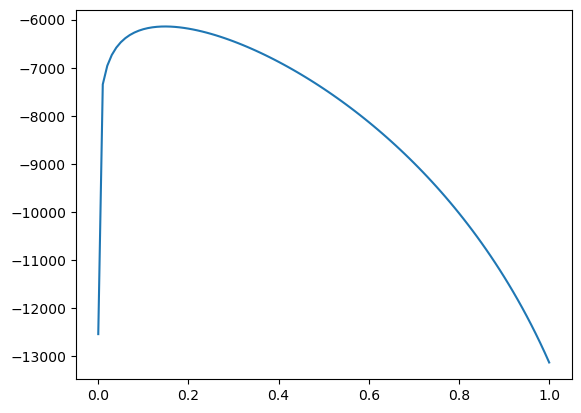

In [127]:
alphas = np.linspace(0, 1, 101)
likes = [get_total_log_like(allData, 1, a) for a in alphas]
likes = [l[0] for l in likes]
plt.plot(alphas, likes)
print(alphas[np.argmax(likes)])

In [184]:
model_likelihood = get_total_log_like(allData, 1.0, 0.15)
print(model_likelihood)

(-6141.517977824123, -5837.3325472017, -6669.922562094359)


In [ ]:
alphas = np.linspace(0, 0.5, 51)
temps = np.linspace(0.5, 5, 46)

print(len(temps)*len(alphas))

2346


### Random assignment

In [95]:
num_3 = len([t for t in ordered_trials if t['DEPTH'] == 3])
num_2 = len([t for t in ordered_trials if t['DEPTH'] == 2])
 
random_2level = np.log(1/3)*13 # categorizing 4 distractors + 9 novel stimuli
random_3level = np.log(1/7)*13
random_likelihood = (random_2level*num_2) + (random_3level*num_3)

print(random_likelihood)

-13125.876881461609


In [15]:

# def total_loglike(all_data, temp):
#     total_log_like = 0.0
#     total_grad = 0.0
#     for trial_data in all_data:
#         log_likes = []
#         grads = []
#         for order_data in trial_data:
#             log_like = 0.0
#             grad = 0.0
#             for sys_scores, choice_idx in order_data:
#                 probs = OCS.softmax(np.array(sys_scores), temp)
#                 log_like += np.log(probs[choice_idx])
#                 true_score = sys_scores[choice_idx]
#                 exp_score = np.sum(probs * sys_scores)
#                 grad += -(true_score - exp_score) / (temp ** 2)
#             log_likes.append(log_like)
#             grads.append(grad)
#         # marginalize across possible unknown orders
#         lse_orders = logsumexp(log_likes)
#         total_log_like += lse_orders - np.log(len(log_likes))        
#         # weight each order's gradient by its posterior p(order|data, T)
#         order_probs = np.exp(log_likes - lse_orders)
#         total_grad += np.sum(order_probs * np.array(grads))
#     return total_log_like, total_grad

# def analyze_participant(cat_assigns, orders, syst, D, lookupTree=None, temp=1):
#     log_likes = []
#     if lookupTree is None:
#         lookupTree = defaultdict(lambda: None)
#     for i_ord in orders:
#         start_syst = copy.deepcopy(syst)
#         log_like = OCS.model_likelihood(start_syst, cat_assigns, i_ord, D, lookupTree, temp)
#         log_likes.append(log_like)
#     marginal_like = logsumexp(log_likes) - np.log(len(orders))
#     max_like = max(log_likes)
#     min_like = min(log_likes)
#     return marginal_like, max_like, min_like

# def estimate_model_likelihood(trials, temp=1):
#     log_like = 0
#     worst_like = 0
#     best_like = 0
#     p = 0
#     order_dic = generate_all_orderings()
#     D, item_hash = OCS.get_distance_mat(item_space)
#     lookupTree = defaultdict(lambda: None) # can only do this here if assuming items are the same across trees. 
#     for t in trials:
#         d, l, o = t['DEPTH'], t['LOC'], t['ORDER']
#         cat_assigns = t['ITEMS']
#         if d== 2:
#             syst = OCS.CategorySystem(item_hash, '..\\..\\Katie2025_AlienTaxonomist\\static_98863bd139ec98cf6bc52549beaaf679\\taxonomies\\tree2D.json')
#         else:
#             syst = OCS.CategorySystem(item_hash, '..\\..\\Katie2025_AlienTaxonomist\\static_98863bd139ec98cf6bc52549beaaf679\\taxonomies\\tree3D.json')
#         orders = order_dic[f'{l}{o}']
#         marginal_like, max_like, min_like = analyze_participant(cat_assigns, orders, syst, D, lookupTree, temp)
#         log_like += marginal_like
#         best_like += max_like
#         worst_like += min_like
#         if p%50 == 0:
#             print(f'{p+1} trials processed')
#         p += 1
#     return log_like, worst_like, best_like
